# 9.0 Performance programming

*Estimated time for this notebook: 10 minutes*

We've spent most of this course looking at how to make code readable and reliable. For research work, it is often also important that code is efficient: that it does what it needs to do *quickly*.

It is very hard to work out beforehand whether code will be efficient or not: it is essential to *profile* code, to measure its performance, to determine what aspects of it are slow.

First, we'll need some code to profile. Let's consider the series

$z_{i+1}=z_{i}^2$ (with $z_0=c$)

In [211]:
def series1(start, iterations=4):
    value = start
    for _ in range(iterations):
        value = value ** 2

    return value


assert series1(0) == 0
assert series1(1) == 1
assert series1(-2) == 65536

In [292]:
# -2 to +2 in steps of 0.1
xmin = -2
xmax = 2
resolution = 300
xstep = (xmax - xmin) / resolution
xs = [(xmin + (xstep * i)) for i in range(resolution)]

In [293]:
zs = [series1(x) for x in xs]

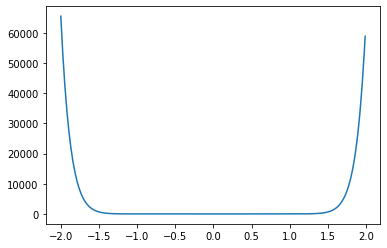

In [294]:
import matplotlib.pyplot as plt

plt.plot(xs, zs)

Note how quickly the series grows outside of +/- 1.

In practice, it is more convenient to calculate the number of iterations before the series surpasses some threshold.

In [295]:
def series2(start, iterations=50):
    value = start

    # Arbitrary threshold, for now
    while abs(value) < 2:

        value = value ** 2

        iterations -= 1
        if iterations < 1:
            break

    return iterations


assert series2(0) == 0
assert series2(1) == 0
assert series2(2) == 50
assert series2(1.5) == 49

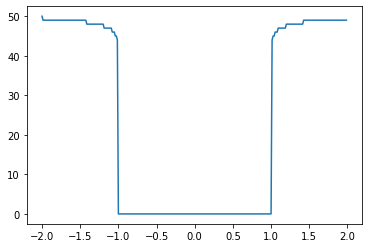

In [296]:
zs = [series2(x) for x in xs]
plt.plot(xs, zs)

We can generalise this to complex numbers (numbers of the form a + ib, where i is the square root of -1). We shall visualise the complex plane by using the x axis for the real components, the y axis for the imaginary component and changing our plot to a heatmap.

To make a complex number in Python, you can use the `complex(real_part, imaginary_part)` function.

In [297]:
complex(5, 6)

(5+6j)

In [298]:
type(complex(5, 6))

complex

In [299]:
# ToDo Explain this
abs(complex(1, 1))

1.4142135623730951

In [370]:
xmin = -3
ymin = -3
xmax = 3
ymax = 3
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]
zs = [[series2(complex(x, y)) for x in xs] for y in ys]

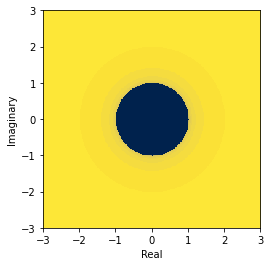

In [371]:
plt.set_cmap("cividis")  # use a color vision deficiency-friendly palette
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(zs, interpolation="none", extent=[xmin, xmax, ymin, ymax])

We see that there is a circle of radius 1 so we know that series will diverge whenever the start point is further than 1 from the origin.

Things get much more interesting when we change the series from

$z_{i+1}=z_{i}^2$ (with $z_0=c$)

to 

$z_{i+1}=z_{i}^2 + c$ (with $z_0=0$)

In [372]:
def mandel1(start, iterations=50):

    value = 0

    # TODO Why 2?
    while abs(value) < 2:

        value = (value ** 2) + start

        iterations -= 1
        if iterations < 1:
            break

    return iterations


assert mandel1(0) == 0
assert mandel1(3) == 49
assert mandel1(0.5) == 45

In [355]:
## Fractals

The boundary of the Mandelbrot set is a fractal.

SyntaxError: invalid syntax (3666923377.py, line 3)

This is the Mandelbrot set. It was first defined and drawn by Robert W. Brooks and Peter Matelski in 1978 but is named after Benoit Mandelbrot, who obtained high quality visualizations of it, in 1980, while working at IBM's Thomas J. Watson Research Center.

Note that it all fits into a circle of radius 2, which is why we use that as our terminating condition.

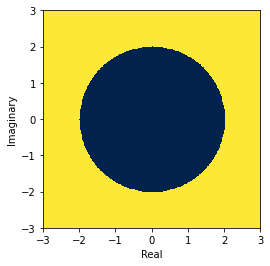

In [374]:
# ToDo Keep this, layer it on top of the image above, or remove it?
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    [[abs(complex(x, y)) > 2 for x in xs] for y in ys],
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
)

## Fractals

The boundary of the Mandelbrot set is a fractal.

ToDo embed wiki commons gif instead of linking to this.

You're probably familiar with a famous fractal called the [Mandelbrot Set](https://www.youtube.com/watch?v=ZDU40eUcTj0).

In [375]:
# ToDo This clearly isn't the bottom left corner of the boundary of the set!
# Have we flipped it somehow? Does numpy draw top left downwards?
xmin = -1
ymin = -1
xmax = 0
ymax = 0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]
zs = [[mandel1(complex(x, y)) for x in xs] for y in ys]

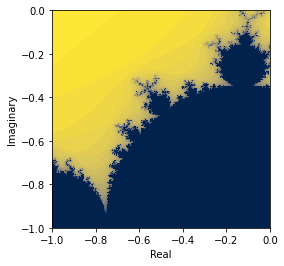

In [376]:
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(zs, interpolation="none", extent=[xmin, xmax, ymin, ymax])

## Timing

We can use the %% timeit magic in a notebook to time a cell.

In [377]:
%%timeit
zs = [[mandel1(complex(x, y)) for x in xs] for y in ys]

568 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


ToDo We should say more about timing.

Our Mandelbrot function will loop up to 50 times for each number in our grid, which is resolution * resolution in size.

We will try to speed our current implementation up by x100.


ToDo do we want to keep any of this explanation?

For a complex number $c$, $c$ is in the Mandelbrot set if the series $z_{i+1}=z_{i}^2+c$ (with $z_0=0$) does not tend to infinity.
Traditionally, we plot a color showing how many steps are needed before $\left|z_i\right|>2$. At this point we are sure that $c$ is *not* in the Mandelbrot set as the series will diverge.